In [1]:
import os
from glob import glob
import json
import torch
import pandas as pd
from collections import defaultdict
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator
import optuna
import matplotlib.pyplot as plt

with open('config.json') as f:
    config = json.load(f)

In [2]:
event_files = glob(os.path.join("runs", "**", "*tfevents*"), recursive=True)


In [3]:
def parse_event_files(event_files: list[str]) -> list[dict]:
    """
    Parse event files to extract equation type, model type, and dimensions.
    
    Args:
        event_files: List of event file paths
        
    Returns:
        list: List of dictionaries containing parsed information
    """
    results = []
    
    for file_path in event_files:
        # Extract the relevant part of the path (between runs/ and /events)
        name_part = file_path.split('runs/')[1].split('/events')[0]
        
        # Initialize info dictionary
        info = {
            'file_path': file_path,
            'equation': None,
            'model_type': None,
            'dimensions': None
        }
        
        # Extract equation type
        if 'heat' in name_part.lower() or 'Heat' in name_part:
            info['equation'] = 'Heat'
        elif 'burger' in name_part.lower() or 'Burger' in name_part:
            info['equation'] = 'Burger'
        elif 'kpz' in name_part.lower() or 'KPZ' in name_part:
            info['equation'] = 'KPZ'
            
        # Extract model type
        if 'MIM' in name_part:
            info['model_type'] = 'MIM'
        elif 'DGM' in name_part:
            info['model_type'] = 'DGM'
            
        # Extract dimensions
        import re
        dim_match = re.search(r'(\d+)D', name_part)
        if dim_match:
            info['dimensions'] = int(dim_match.group(1))
            
        results.append(info)
        
    return results

In [4]:
runs = parse_event_files(event_files)

In [5]:
losses = {}
train_times = {}
for run in runs:
    dims = run['dimensions']
    equation = run['equation']
    model = run['model_type']
    if model == 'MIM' and equation != "Heat":
        dims /= 8
    if equation not in losses:
        losses[equation] = {}
        train_times[equation] = {}
    if dims not in losses[equation]:
        losses[equation][dims] = {}
        train_times[equation][dims] = {}
    if model not in losses[equation][dims]:
        losses[equation][dims][model] = []
                
    path = run['file_path']
    event_acc = EventAccumulator(path)
    event_acc.Reload()  # Load all data
    tags = event_acc.Tags()["scalars"]
    results = defaultdict(list)
    # Extract data for each tag
    for tag in tags:
        events = event_acc.Scalars(tag)
        
        # Extract step and value, ignore wall_time
        for event in events:
            results[tag].append((event.value, event.wall_time))
    # Extract loss
    sub_losses = results['Loss/unadjusted_total_loss']
    losses[equation][dims][model].extend([l[0] for l in sub_losses])
    # Extract train time
    train_time = sub_losses[-1][1] - sub_losses[0][1]
    train_times[equation][dims][model] = train_time

In [6]:
losses.keys()

dict_keys(['Burger', 'Heat', 'KPZ'])

In [7]:
import numpy as np

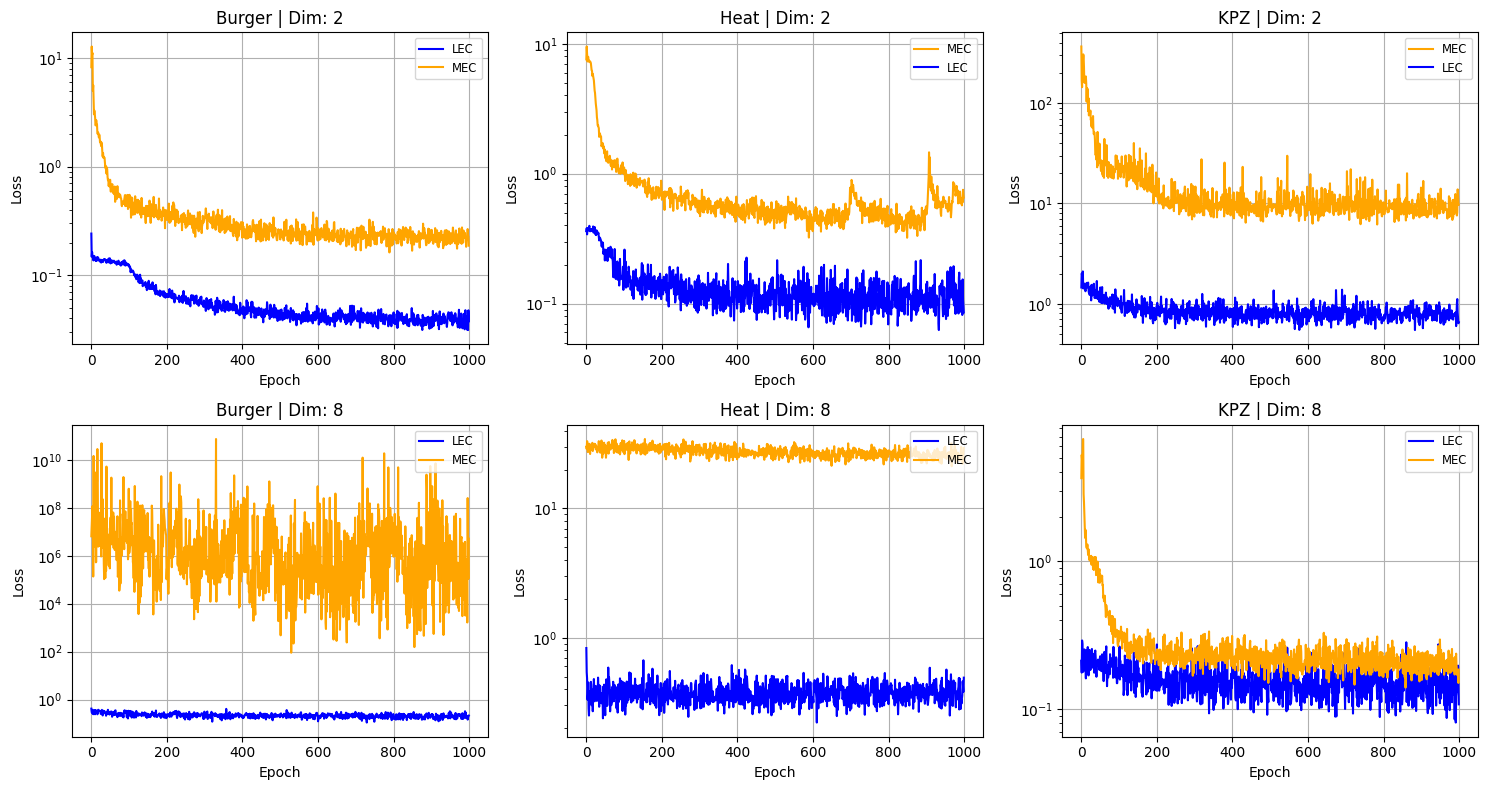

In [8]:
equations = sorted(losses.keys())

# Instead of basing the subplot grid on the maximum number of dims per equation,
# we take the union of all dimensions across equations.
dims_all = sorted(set.union(*(set(losses[eq].keys()) for eq in equations)))

# Now, define the number of rows and columns for the subplot grid.
# Each row will correspond to a dimension (dim) and each column to an equation.
n_rows = len(dims_all)
n_cols = len(equations)

# Create the figure and axes.
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols,
                         figsize=(5 * n_cols, 4 * n_rows),
                         squeeze=False)

# Loop over each dimension (row) and each equation (column)
for i, dim in enumerate(dims_all):
    for j, eq in enumerate(equations):
        ax = axes[i, j]
        
        # Check if this equation has data for the current dimension
        if dim in losses[eq]:
            # Loop over the models in this equation/dimension
            for model, loss_list in losses[eq][dim].items():
                epochs = np.arange(len(loss_list))  # Epochs from 0 to len(loss_list)-1
                train_time = train_times[eq][dim][model]
                if model == "MIM":
                    color = "orange"
                    label = "MEC"
                else:
                    color = "blue"
                    label = "LEC"
                    
                ax.plot(epochs, loss_list, label=label, color=color)
            
            ax.set_title(f"{eq} | Dim: {dim}")
            ax.set_xlabel("Epoch")
            ax.set_ylabel("Loss")
            ax.set_yscale("log")  # Set y-axis to logarithmic scale
            ax.legend(fontsize='small', loc='upper right')
            ax.grid(True)
        else:
            # If no data exists for this equation and dimension, disable the subplot.
            ax.axis("off")

plt.tight_layout()
plt.show()

In [9]:
dims = config["dims"]

In [10]:
from heat_train import HeatTrainDGM
from burger_train import BurgerTrainDGM
from kpz_train import KPZTrainDGM
from accelerate import Accelerator
from utils.white_noise import BrownianSheet
import gc
import time
import pickle

accelerator = Accelerator()
sheet = BrownianSheet(device=accelerator.device)


In [11]:
# Create all tensors on CPU first
def sample_points(n_points, dims, equation:str):
    boundaries = [(0, 1) for _ in range(dims)]
    t = torch.rand((n_points, 1))
    log_a, log_b = torch.log(torch.tensor(1e-10)), torch.log(torch.tensor(1.0))
    nu = torch.exp(torch.empty(n_points, 1).uniform_(log_a, log_b))
    coords = [torch.rand((n_points, 1)) for _ in range(len(boundaries))]

    # Move all tensors to the same device before concatenation
    t = t.to(accelerator.device)
    nu = nu.to(accelerator.device)
    coords = [c.to(accelerator.device) for c in coords]
    points = torch.cat([t] + coords, dim=1)
    ws = [sheet.simulate(points) for _ in range(1)]
    if equation == "burger":
        alpha = torch.rand((n_points, 1)).to(accelerator.device)
        return t, nu, alpha, coords, ws
    if equation == "kpz":
        lambda_kpz = torch.rand((n_points, 1)).to(accelerator.device)
        alpha = torch.rand((n_points, 1)).to(accelerator.device)
        return t, nu, alpha, lambda_kpz, coords, ws
    return t, nu, coords, ws

In [ ]:
n_points = 10000
batch_size = 1000
equations = ["heat", "burger", "kpz"]
evals = {}
infrence_times = {}
for equation in equations:
    if os.path.exists("evals.pkl"):
        with open("evals.pkl", "rb") as f:
            evals = pickle.load(f)
        with open("infrence_times.pkl", "rb") as f:
            infrence_times = pickle.load(f)
        break
    if not evals.get(equation):
        evals[equation] = {}
    if not infrence_times.get(equation):
        infrence_times[equation] = {}
    if equation == "heat":
        trainer = HeatTrainDGM(batch_size)
    elif equation == "burger":
        trainer = BurgerTrainDGM(batch_size)
    elif equation == "kpz":
        trainer = KPZTrainDGM(batch_size)
    for dim in dims:
        if not evals[equation].get(dim):
            evals[equation][dim] = {}
        if not infrence_times[equation].get(dim):
            infrence_times[equation][dim] = {}
        dgm_model = torch.load(f"models/dgm_{equation}_{dim}D.pth")
        samples = sample_points(n_points, dim, equation)
        evals[equation][dim]["LEC"] = {}
        boundaries = [(0, 1) for _ in range(dim)]
        start_time = time.time()
        sub_dgm_losses = trainer.forward(dgm_model, *samples, boundaries=boundaries)
        end_time = time.time()
        infrence_times[equation][dim]["LEC"] = end_time - start_time
        initial_loss = sub_dgm_losses["initial_loss"].item()
        boundary_loss = sub_dgm_losses["boundary_loss"].item()
        residual_loss = sub_dgm_losses["Avg. Residual Loss"].item()
        evals[equation][dim]["LEC"]["initial_loss"] = initial_loss
        evals[equation][dim]["LEC"]["boundary_loss"] = boundary_loss
        evals[equation][dim]["LEC"]["residual_loss"] = residual_loss
        
        mim_model = torch.load(f"models/mim_{equation}_{dim}D.pth")
        evals[equation][dim]["MEC"] = {}
        start_time = time.time()
        sub_mim_losses = trainer.forward(mim_model, *samples, boundaries=boundaries)
        end_time = time.time()
        infrence_times[equation][dim]["MEC"] = end_time - start_time
        initial_loss = sub_mim_losses["initial_loss"].item()
        boundary_loss = sub_mim_losses["boundary_loss"].item()
        residual_loss = sub_mim_losses["Avg. Residual Loss"].item()
        evals[equation][dim]["MEC"]["initial_loss"] = initial_loss
        evals[equation][dim]["MEC"]["boundary_loss"] = boundary_loss
        evals[equation][dim]["MEC"]["residual_loss"] = residual_loss
        
        del mim_model, dgm_model, samples
        torch.cuda.empty_cache()
        gc.collect()
with open("evals.pkl", "wb") as f:
    pickle.dump(evals, f)
with open("infrence_times.pkl", "wb") as f:
    pickle.dump(infrence_times, f)

In [17]:
rows = []
for equation, dims in evals.items():
    for dimension, models in dims.items():
        for model, metrics in models.items():
            # Create a row with equation, dimension, model and the metrics
            row = {
                'equation': equation,
                'dimension': dimension,
                'model': model,
                **metrics
            }
            rows.append(row)

# Create a DataFrame.
df = pd.DataFrame(rows)

# Convert 'equation' into a categorical column with the desired order.
desired_order = ["heat", "burger", "kpz"]
df["equation"] = pd.Categorical(df["equation"], categories=desired_order, ordered=True)

# Sort the DataFrame by the new categorical order along with the other indices.
df.sort_values(["equation", "dimension", "model"], inplace=True)

# Optionally, set a MultiIndex for clarity.
df.set_index(["equation", "dimension", "model"], inplace=True)

print(df)

                          initial_loss  boundary_loss  residual_loss
equation dimension model                                            
heat     2         LEC        0.010987   7.063125e-04   2.776830e-02
                   MEC        0.000000   1.305470e-01   7.064529e-01
         8         LEC        0.357987   4.256520e-12   5.207272e-14
                   MEC        0.000000   6.646921e+00   4.785810e+01
burger   2         LEC        0.016587   2.375295e-03   8.530067e-03
                   MEC        0.000000   1.912086e-14   2.435699e+02
         8         LEC        0.148533   7.250326e-03   2.661702e-02
                   MEC        0.000000   9.308832e-14   3.513861e+02
kpz      2         LEC        0.140445   1.271365e-02   3.081935e-01
                   MEC        0.000000   4.965307e-14   2.000074e+01
         8         LEC        0.002083   1.137943e-03   1.045877e-02
                   MEC        0.000000   5.825353e-15   5.127285e-01


In [23]:
# --- Flatten the inference_times dictionary ---
rows_inf = []
for eq, dims in infrence_times.items():
    for dim, models in dims.items():
        for model, time in models.items():
            rows_inf.append({
                'equation': eq,           # already in desired lower-case
                'dimension': int(dim),    # force dims to integer (e.g., 2.0 -> 2)
                'model': model,           # either "LEC" or "MEC"
                'inference_time': time
            })

df_inf = pd.DataFrame(rows_inf)

# --- Flatten the train_times dictionary ---
rows_train = []
for eq, dims in train_times.items():
    eq_lower = eq.lower()  # Convert equation name to lower-case for consistency.
    for dim, models in dims.items():
        for model, time in models.items():
            # Rename model: 'DGM' becomes 'LEC' and 'MIM' becomes 'MEC'
            new_model = model
            if model == 'DGM':
                new_model = 'LEC'
            elif model == 'MIM':
                new_model = 'MEC'
            rows_train.append({
                'equation': eq_lower,
                'dimension': int(dim),
                'model': new_model,
                'train_time': time
            })

df_train = pd.DataFrame(rows_train)

# --- Merge the two DataFrames on equation, dimension, and model ---
df_merged = pd.merge(df_train, df_inf, on=['equation', 'dimension', 'model'], how='outer')

# --- Order the equation categories as desired ---
desired_order = ["heat", "burger", "kpz"]
df_merged["equation"] = pd.Categorical(df_merged["equation"], categories=desired_order, ordered=True)
df_merged.sort_values(["equation", "dimension", "model"], inplace=True)

# --- Optionally set a MultiIndex for a nice look ---
df_merged.set_index(["equation", "dimension", "model"], inplace=True)

df_merged["train_time"] = df_merged["train_time"].astype(int)
df_merged["inference_time"] = df_merged["inference_time"].round(4)

# Display the final DataFrame
print(df_merged)

                          train_time  inference_time
equation dimension model                            
heat     2         LEC          1917          1.3277
                   MEC           863          0.4732
         8         LEC          1664          0.9578
                   MEC          1372          4.9820
burger   2         LEC          2468          1.1285
                   MEC          7446          1.5130
         8         LEC         11244          1.9134
                   MEC         25931          7.4671
kpz      2         LEC          2758          0.8313
                   MEC          1657          1.7529
         8         LEC          5889          2.1808
                   MEC          7140          7.1282
